In [149]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
from scipy.optimize import curve_fit
import corner
import matplotlib as mpl
%matplotlib inline

In [150]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as so

def find_confidence_interval(x, pdf, confidence_level):
    return pdf[pdf > x].sum() - confidence_level

def density_contour(xdata, ydata, nbins_x, nbins_y, ax=None, **contour_kwargs):
    """ Create a density contour plot. 
    Source code: Adrian Price-Whelan https://gist.github.com/adrn/3993992
    Parameters
    ----------
    xdata : numpy.ndarray
    ydata : numpy.ndarray
    nbins_x : int
        Number of bins along x dimension
    nbins_y : int
        Number of bins along y dimension
    ax : matplotlib.Axes (optional)
        If supplied, plot the contour to this axis. Otherwise, open a new figure
    contour_kwargs : dict
        kwargs to be passed to pyplot.contour()
    """

    H, xedges, yedges = np.histogram2d(xdata, ydata, bins=(nbins_x,nbins_y), normed=True)
    x_bin_sizes = (xedges[1:] - xedges[:-1]).reshape((1,nbins_x))
    y_bin_sizes = (yedges[1:] - yedges[:-1]).reshape((nbins_y,1))

    pdf = (H*(x_bin_sizes*y_bin_sizes))

    one_sigma = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.68))
    two_sigma = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.95))
    three_sigma = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.99))
    levels = [one_sigma, two_sigma, three_sigma]

    X, Y = 0.5*(xedges[1:]+xedges[:-1]), 0.5*(yedges[1:]+yedges[:-1])
    Z = pdf.T

    if ax == None:
        contour = plt.contour(X, Y, Z, levels=levels, origin="lower", **contour_kwargs)
    else:
        contour = ax.contour(X, Y, Z, levels=levels, origin="lower", **contour_kwargs)

    return contour

In [151]:
def set_ticklabels(ax, size=18):
    ticklabels_x = ax.get_xticklabels()
    ticklabels_y = ax.get_yticklabels()

    for label_x in ticklabels_x:
        label_x.set_fontsize(size)
        label_x.set_family('serif')
    for label_y in ticklabels_y:
        label_y.set_fontsize(size)
        label_y.set_family('serif')

In [152]:
def main_halos(snap_data):
    sorted_vmax = snap_data['vmax']
    sorted_vmax = np.sort(sorted_vmax)
    v_max_A = sorted_vmax[-1]
    v_max_B = sorted_vmax[-2]
    v_max_C = sorted_vmax[-3]
    ii = snap_data['vmax']==v_max_A
    jj = snap_data['vmax']==v_max_B
    #kk = snap_data['vmax']==v_max_C
    index = (ii | jj)
    #print sorted_vmax[-3::]
    main_halos_data = snap_data[index]
    if(main_halos_data['vmax'][0] < main_halos_data['vmax'][1]):
        tmp = main_halos_data[0].copy()
        main_halos_data[0] = main_halos_data[1].copy()
        main_halos_data[1] = tmp.copy()
    return main_halos_data

In [153]:
def satellite_halos(halo_data, halo_center):
    tmp_halo = halo_data.copy()
    radius = halo_center['vmax']/(10.0 * 100) * 1000 # in kpc/h
    for col in list(['x','y','z']):
        tmp_halo[col] = tmp_halo[col] - halo_center[col]
    r = np.sqrt(tmp_halo['x']**2 + tmp_halo['y']**2 + tmp_halo['z']**2)
    ii = r < radius
    return halo_data[ii]

In [154]:
def load_snapshot(snap_name, boxsize=75000.0):
    dtype=[('subid','i8'),
           ('x', 'f8'),
           ('y', 'f8'), 
           ('z', 'f8'),
           ('vx', 'f8'),
           ('vy', 'f8'),
           ('vz', 'f8'),
           ('vmax', 'f8'),
           ('bmag', 'f8')]
    snap_data = np.loadtxt(snap_name, dtype=dtype)    
    # this takes into account periodic boudary conditions
    for col in list(['x','y','z']):
        if((snap_data[col].max() - snap_data[col].min()) > 0.5 * boxsize):
            snap_data[col] = (snap_data[col] - 0.5 * boxsize) % boxsize
        
    return snap_data

In [155]:
def load_obs(obs_name):
    dtype=[('name','|S20'),
           ('x', 'f8'),
           ('y', 'f8'), 
           ('z', 'f8'),
           ('delta_plus', 'f8'),
           ('delta_minus', 'f8'),
           ('bmag', 'f8'),
           ('delta_vmag', 'f8')]
    obs_data = np.loadtxt(obs_name, dtype=dtype)    
    return obs_data

In [156]:
def get_best_plane(halo_data, halo_center, bright=True, all_points=False ,plotting=False):
    
    if all_points==False:
        satellite_data = satellite_halos(halo_data, halo_center)
    else:
        satellite_data = halo_data.copy()
        
    if bright:
        ii = satellite_data['bmag'] < -9.0
        subset_satellite_data = satellite_data[ii]
    else:
        subset_satellite_data = satellite_data.copy()   

    
    #create vectors defining the planes
    n_vectors = 1000
    costheta = (np.random.random(n_vectors)-0.5)*2.0
    theta = np.cos(costheta)
    phi = np.random.random(n_vectors) * 2.0 * np.pi
    unit_vectors = np.zeros((n_vectors,3))
    unit_vectors[:,0] = np.sin(theta) * np.cos(phi)
    unit_vectors[:,1] = np.sin(theta) * np.sin(phi)
    unit_vectors[:,2] = np.cos(theta)

    #create arrays storing distances to all planes
    n_satellites = len(subset_satellite_data)
    pos_satellites = np.zeros((n_satellites,3))

    col = list(['x','y','z'])
    for i in range(3):
        pos_satellites[:,i] = subset_satellite_data[col[i]] - halo_center[col[i]]
    pos_satellites = np.transpose(pos_satellites)
    
    # find distances of all points to all planes
    distances_to_planes = np.dot(unit_vectors, pos_satellites)
    percentiles = np.percentile(distances_to_planes, [16,50,84], axis=1)
    delta_plane = percentiles[2,:]-percentiles[0,:]
    
    # the best plane is the one with the minimum width
    i_min = np.argmin(delta_plane)
    plane_delta = delta_plane[i_min]
    plane_center = percentiles[1,i_min]
    plane_vector = unit_vectors[i_min,:]
    
    if plotting:
        plt.scatter(delta_plane, percentiles[1,:])
    return plane_delta, plane_center, plane_vector

In [157]:
def inertiaTensor(x,y,z, unit_vector=np.array([1.0,0.0,0.0])):
    I=[]
    for index in range(9):
        I.append(0)
   
    I[0] = np.sum(y*y+z*z) 
    I[1] = np.sum(-y*x)    
    I[2] = np.sum(-x*z)    
    I[3] = np.sum(-y*x)    
    I[4] = np.sum(x*x+z*z) 
    I[5] = np.sum(-y*z)    
    I[6] = np.sum(-z*x)    
    I[7] = np.sum(-z*y)    
    I[8] = np.sum(x*x+y*y) 

    tensor = np.array([(I[0:3]), (I[3:6]), (I[6:9])])
    vals, vects = np.linalg.eig(tensor)  # they come out unsorted, so the command below is needed
    eig_ord = np.argsort(vals)  # a thing to note is that here COLUMN i corrensponds to eigenvalue i.
    ord_vals = vals[eig_ord]
    ord_vects = vects[:, eig_ord].T

    TriaxParam = (ord_vals[2]**2  - ord_vals[1]**2)/(ord_vals[2]**2 - ord_vals[0]**2)
    AxisRatio = ord_vals[0]/ord_vals[2]
    return ord_vals, np.fabs(np.dot(ord_vects[0],unit_vector)), TriaxParam, AxisRatio, ord_vects

def inertiaTensorHalo(halo_data, halo_center, unit_vector=np.array([1.0,0.0,0.0])):
    x = halo_data['x'] - halo_center['x']
    y = halo_data['y'] - halo_center['y']
    z = halo_data['z'] - halo_center['z']
    
    return inertiaTensor(x,y,z,unit_vector=unit_vector)


In [158]:
def gen_random_sphere(n_points):
    """
    Sets of points in the sphere
    """
    r = np.random.random(n_points)**(1.0/3.0)
    phi = np.random.random(n_points) * 2.0 * np.pi
    costheta = 2.0*(np.random.random(n_points) -0.5)
    theta = np.arccos(costheta)
    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(theta)
    return x, y, z

In [159]:
def sample_cos_ABX(N_points_A=21, N_points_B=32):
    """
    Sample the tensor alignment between two spheres sampled with
    different number of points.
    """
    x, y, z = gen_random_sphere(N_points_A)
    eigenval, _ , triax, axis_ratio, eigenvec = inertiaTensor(x,y,z)
    main_eigenvec_A = eigenvec[2]/sum(eigenvec[2]**2)

    x, y, z = gen_random_sphere(N_points_B)
    eigenval, _, triax, axis_ratio, eigenvec = inertiaTensor(x,y,z)
    main_eigenvec_B = eigenvec[2]/sum(eigenvec[2]**2)

    cos_AB = abs(sum(main_eigenvec_A * main_eigenvec_B))
    cos_AX = abs(main_eigenvec_A[0])
    cos_BX = abs(main_eigenvec_B[0])
    return cos_AB, cos_AX, cos_BX

In [160]:
def sample_pairs(list_N_points_A=list([10]), list_N_points_B=list([20])):
    """
    Sample lists of pairs and get the median of their alignments.
    """
    M = len(list_N_points_A)
    cos_AB_array = np.zeros(M)
    cos_AX_array = np.zeros(M)
    cos_BX_array = np.zeros(M)

    for i in range(M):
        cos_AB_array[i], cos_AX_array[i], cos_BX_array[i] = \
            sample_cos_ABX(N_points_A = list_N_points_A[i], N_points_B = list_N_points_B[i])
        
    cos_AB_array.sort()
    cos_AX_array.sort()
    cos_BX_array.sort()
    return np.median(cos_AB_array), np.median(cos_AX_array), np.median(cos_BX_array)

In [161]:
def monte_carlo_sample_pairs(n_monte_carlo=1000, list_N_points_A=list([10]), list_N_points_B=list([20])):
    median_AB = np.zeros(n_monte_carlo)
    median_AX = np.zeros(n_monte_carlo)
    median_BX = np.zeros(n_monte_carlo)

    for i in range(n_monte_carlo):
        m_AB, m_AX, m_BX = sample_pairs(list_N_points_A=list_N_points_A, list_N_points_B=list_N_points_B)
        median_AB[i] = m_AB
        median_AX[i] = m_AX
        median_BX[i] = m_BX
    return median_AB, median_AX, median_BX


In [162]:
n_pairs = 53
v_circ_A = np.zeros(n_pairs)
v_circ_B = np.zeros(n_pairs)
v_circ_C = np.zeros(n_pairs)
distance_AB = np.zeros(n_pairs)
velocity_AB = np.zeros(n_pairs)
n_bright = np.zeros(n_pairs)
n_total = np.zeros(n_pairs)
n_bright_A = np.zeros(n_pairs)
n_bright_B = np.zeros(n_pairs)
n_dark_A  = np.zeros(n_pairs)
n_dark_B = np.zeros(n_pairs)
distance_radius_ratio = np.zeros(n_pairs)
triax_bright_A = np.zeros(n_pairs)
triax_bright_B = np.zeros(n_pairs)
axratio_bright_A = np.zeros(n_pairs)
axratio_bright_B = np.zeros(n_pairs)
triax_dark_A = np.zeros(n_pairs)
triax_dark_B = np.zeros(n_pairs)
axratio_dark_A = np.zeros(n_pairs)
axratio_dark_B = np.zeros(n_pairs)
r_AB = np.zeros((n_pairs,3))
dot_product_r_bright_A = np.zeros(n_pairs)
dot_product_r_bright_B = np.zeros(n_pairs)
dot_product_r_dark_A = np.zeros(n_pairs)
dot_product_r_dark_B = np.zeros(n_pairs)
plane_width_bright_A = np.zeros(n_pairs)
plane_width_dark_A = np.zeros(n_pairs)
plane_width_bright_B = np.zeros(n_pairs)
plane_width_dark_B = np.zeros(n_pairs)

for i in range(n_pairs):
    filename = "../data/dm_selected/Illustris_group_{}.dat".format(i)
    data = load_snapshot(filename)
    main_h_data = main_halos(data)
    satellite_data_A = satellite_halos(data, main_h_data[0])
    satellite_data_B = satellite_halos(data, main_h_data[1])
    
    
    v_circ_A[i] = main_h_data['vmax'][0]
    v_circ_B[i] = main_h_data['vmax'][1]
    radius_A = main_h_data['vmax'][0]/(10.0 * 100) * 1000 # in kpc/h
    radius_B = main_h_data['vmax'][1]/(10.0 * 100) * 1000 # in kpc/h
    
    r_AB[i][0] = main_h_data['x'][1] - main_h_data['x'][0]
    r_AB[i][1] = main_h_data['y'][1] - main_h_data['y'][0]
    r_AB[i][2] = main_h_data['z'][1] - main_h_data['z'][0]
    r_AB[i] = r_AB[i]/np.sqrt(np.sum(r_AB[i]**2))
    #print r_AB[i]
    
    distance_AB[i] =  np.sqrt((main_h_data['x'][0] - main_h_data['x'][1])**2 \
                    + (main_h_data['y'][0] - main_h_data['y'][1])**2 \
                    + (main_h_data['z'][0] - main_h_data['z'][1])**2)
    velocity_AB[i] = np.sqrt((main_h_data['vx'][0] - main_h_data['vx'][1])**2 \
                    + (main_h_data['vy'][0] - main_h_data['vy'][1])**2 \
                    + (main_h_data['vz'][0] - main_h_data['vz'][1])**2)
    
    #best planes
    plane_width_bright_A[i], _, _ =get_best_plane(data, main_h_data[0], bright=True)
    plane_width_dark_A[i], _, _ =get_best_plane(data, main_h_data[0], bright=False)
    plane_width_bright_B[i], _, _ =get_best_plane(data, main_h_data[1], bright=True)
    plane_width_dark_B[i], _, _ =get_best_plane(data, main_h_data[1], bright=False)

    # alignments with the vector joining the two halos    
    ii = satellite_data_A['bmag'] < 0.0
    n_bright_A[i] = len(satellite_data_A[ii])
    n_dark_A[i] = len(satellite_data_A)
    _,dot_product_r_bright_A[i],triax_bright_A[i],axratio_bright_A[i],_ = \
        inertiaTensorHalo(satellite_data_A[ii], main_h_data[0], unit_vector=r_AB[i])
        
    _,dot_product_r_dark_A[i],triax_dark_A[i],axratio_dark_A[i],_ = \
        inertiaTensorHalo(satellite_data_A, main_h_data[0], unit_vector=r_AB[i])
    
    ii = satellite_data_B['bmag'] < 0.0
    n_bright_B[i] = len(satellite_data_B[ii])
    n_dark_B[i] = len(satellite_data_B)
    _,dot_product_r_bright_B[i],triax_bright_B[i],axratio_bright_B[i],_ = \
        inertiaTensorHalo(satellite_data_B[ii], main_h_data[1], unit_vector=r_AB[i])
    
    _,dot_product_r_dark_B[i],triax_dark_B[i],axratio_dark_B[i],_ = \
        inertiaTensorHalo(satellite_data_B, main_h_data[1], unit_vector=r_AB[i])
    
    n_total[i] = len(data)
    ii = data['bmag'] < 0
    n_bright[i] = len(data[ii])
    #if((distance_AB[i] > 700.0) & (distance_AB[i]<1400) & (velocity_AB[i]>100.0)):
    #    print('halo file {}'.format(i))
    distance_radius_ratio[i] = distance_AB[i]/(radius_A + radius_B)
    if(distance_AB[i] < (radius_A + radius_B)):
        print('halo file {} are touching'.format(i))
        print('distance {} : radius_sum {}'.format(distance_AB[i], radius_A+radius_B))

halo file 0 are touching
distance 132.329152767 : radius_sum 486.785492
halo file 6 are touching
distance 403.063577143 : radius_sum 421.533783
halo file 31 are touching
distance 170.300808893 : radius_sum 436.534836
halo file 51 are touching
distance 119.860027673 : radius_sum 387.000824


In [163]:
MW_data = load_obs("../data/obs/MW_satellites.txt")
M31_data = load_obs("../data/obs/M31_satellites.txt")

MW_plane_delta, MW_plane_center, MW_plane_vector = get_best_plane(MW_data, MW_data[0], all_points=True)
M31_plane_delta, M31_plane_center, M31_plane_vector = get_best_plane(M31_data, M31_data[0], all_points=True)


ii = MW_data['bmag']<-9.0
n_MW = len(MW_data[ii])
ii = M31_data['bmag']<-9.0
n_M31 = len(M31_data[ii])

r_LG = np.zeros(3)
r_LG[0] = MW_data['x'][0] - M31_data['x'][0]
r_LG[1] = MW_data['y'][0] - M31_data['y'][0]
r_LG[2] = MW_data['z'][0] - M31_data['z'][0]
r_LG = r_LG/np.sqrt(np.sum(r_LG**2))


ii = MW_data['bmag'] < -9.0
_,dot_product_r_MW, triax_MW, axratio_MW,_ = \
        inertiaTensorHalo(MW_data[ii], MW_data[0], unit_vector=r_LG)

ii = M31_data['bmag'] < -9.0
_,dot_product_r_M31, triax_M31, axratio_M31,_ = \
        inertiaTensorHalo(M31_data[ii], M31_data[0], unit_vector=r_LG)

print n_MW, n_M31
print(MW_plane_delta, M31_plane_delta)
print(dot_product_r_MW, dot_product_r_M31)

11 21
(50.51691528766959, 128.74514857719385)
(0.38674352854212735, 0.011841869708923813)


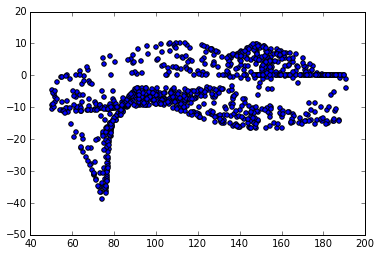

In [164]:
MW_plane_delta, MW_plane_center, MW_plane_vector = get_best_plane(MW_data, MW_data[0], all_points=True, plotting=True)

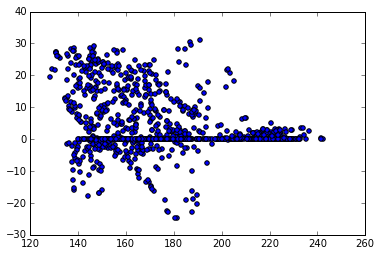

In [165]:
M31_plane_delta, M31_plane_center, M31_plane_vector = get_best_plane(M31_data, M31_data[0], all_points=True, plotting=True)

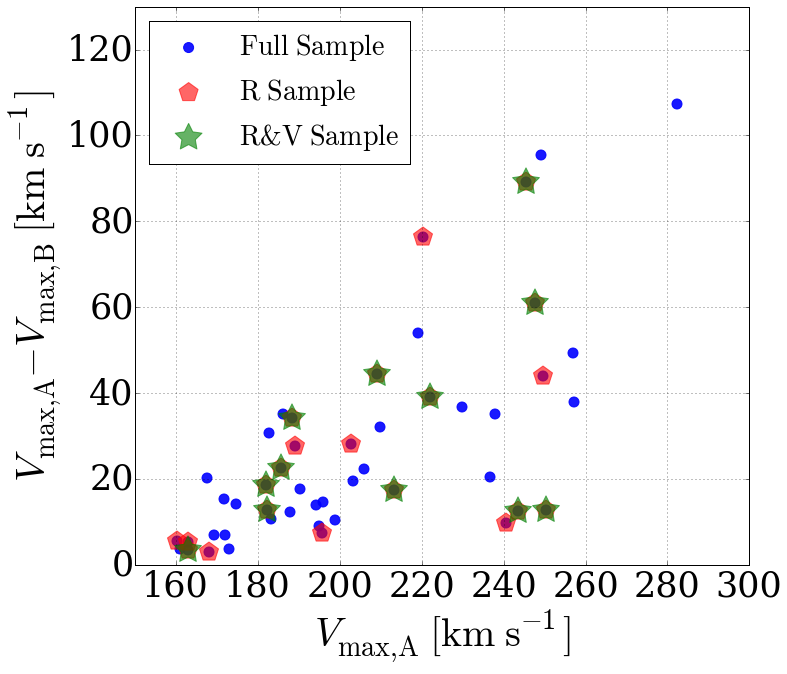

In [166]:
fig = plt.figure(1, figsize=(11,10))
ax = plt.axes()
set_ticklabels(ax, size=35)

ii = (distance_AB > 0) & (distance_radius_ratio > 1.0)
plt.scatter(v_circ_A[ii], v_circ_A[ii] - v_circ_B[ii], label='$\mathrm{Full\ Sample}$',s=100,alpha=0.9,color='b')

ii = (distance_AB > 700.0) & (distance_AB<1400) & (distance_radius_ratio > 1.0)
plt.scatter(v_circ_A[ii], v_circ_A[ii] - v_circ_B[ii], label='$\mathrm{R\ Sample}$',
            s=400,alpha=0.6,color='r', marker=(5,0))


ii = (distance_AB > 700.0) & (distance_AB<1400) & (velocity_AB>100) & (distance_radius_ratio > 1.0)
plt.scatter(v_circ_A[ii], v_circ_A[ii] - v_circ_B[ii], label='$\mathrm{R&V\ Sample}$',
            s=800,alpha=0.6,color='green', marker=(5,1))

ax.grid(True)

ax.set_xlim([150,300])
ax.set_ylim([0.0,130])

plt.xlabel(r'$V_{\rm{max,A}}\ [\rm{km\ s^{-1}}]$', size=40)
plt.ylabel(r'$V_{\rm{max,A}} - V_{\rm{max,B}}\ [\rm{km\ s^{-1}}]$', size=40)
plt.legend(loc=2, prop={'size':28}, scatterpoints=1)
plt.savefig('../paper/v_circ_pairs.pdf', bbox_inches='tight')

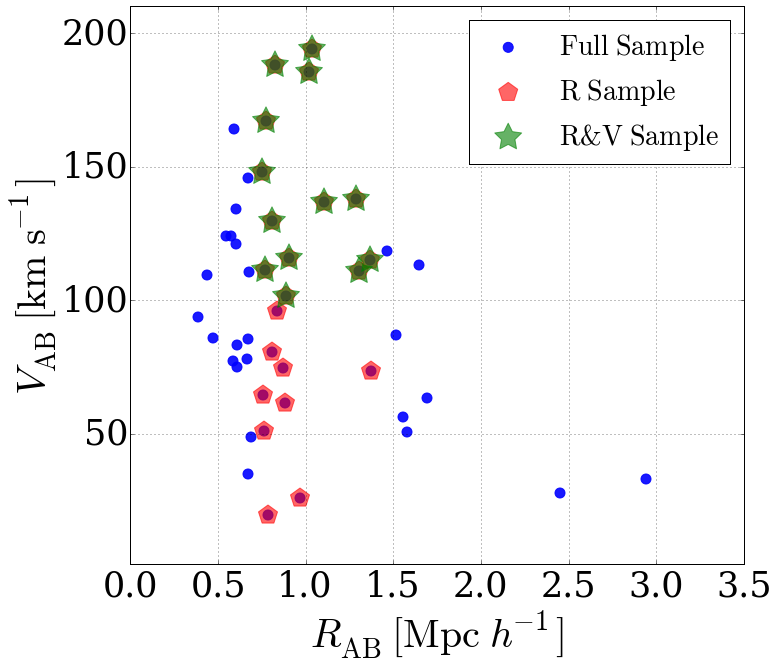

In [195]:
fig = plt.figure(1, figsize=(11,10))
ax = plt.axes()
set_ticklabels(ax, size=35)

ifull = (distance_AB > 0) & (distance_radius_ratio > 1.0)
plt.scatter(distance_AB[ifull]/1000.0, velocity_AB[ifull], label='$\mathrm{Full\ Sample}$',s=100,alpha=0.9,color='b')

irsample = (distance_AB > 700.0) & (distance_AB<1400) & (distance_radius_ratio > 1.0)
plt.scatter(distance_AB[irsample]/1000, velocity_AB[irsample], label='$\mathrm{R\ Sample}$',
            s=400,alpha=0.6,color='r', marker=(5,0))


irvsample = (distance_AB > 700.0) & (distance_AB<1400) & (velocity_AB>100) & (distance_radius_ratio > 1.0)
plt.scatter(distance_AB[irvsample]/1000, velocity_AB[irvsample], label='$\mathrm{R&V\ Sample}$',
            s=800,alpha=0.6,color='green', marker=(5,1))

ax.set_xlim([0.0,3.5])
ax.set_ylim([1,210])
ax.grid(True)

#plt.yscale('log')
#plt.xscale('log')

plt.xlabel(r'$R_{\rm{AB}} \ [{\rm{Mpc}}\ h^{-1}]$', size=40)
plt.ylabel(r'$V_{\rm{AB}}\ [\rm{km\ s^{-1}}]$', size=40)
plt.legend(loc=1, prop={'size':28}, scatterpoints=1)
plt.savefig('../paper/v_r_pairs.pdf', bbox_inches='tight')

#plt.scatter(distance_AB[ii], velocity_AB[ii])

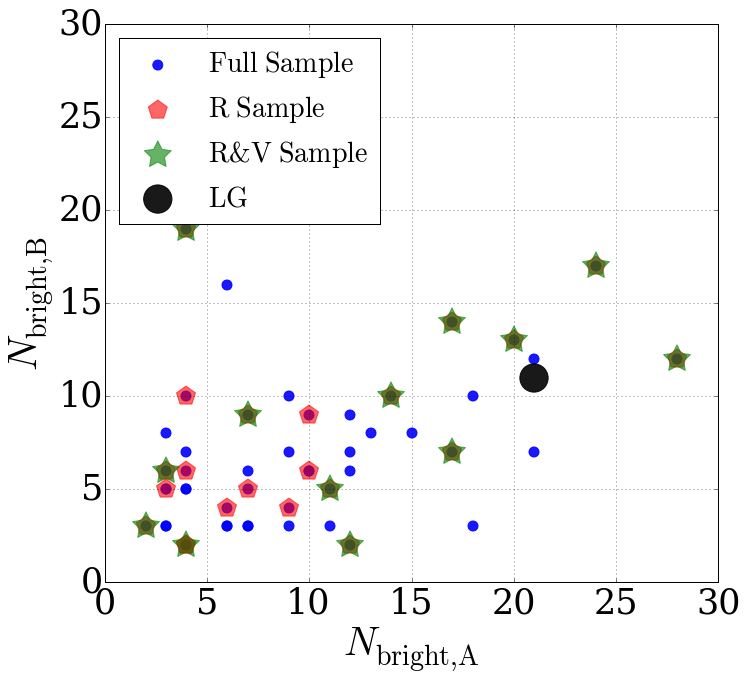

In [168]:
pfig = plt.figure(1, figsize=(11,10))
ax = plt.axes()
set_ticklabels(ax, size=35)

plt.scatter(n_bright_A[ifull], n_bright_B[ifull],label='$\mathrm{Full\ Sample}$',s=100,alpha=0.9,color='b')

plt.scatter(n_bright_A[irsample], n_bright_B[irsample], label='$\mathrm{R\ Sample}$',
            s=400,alpha=0.6,color='r', marker=(5,0))


plt.scatter(n_bright_A[irvsample], n_bright_B[irvsample], label='$\mathrm{R&V\ Sample}$',
            s=800,alpha=0.6,color='green', marker=(5,1))

plt.scatter(n_M31, n_MW, label='$\mathrm{LG}$',
            s=800,alpha=0.9,color='black', marker='o')

ax.set_xlim([0,30])
ax.set_ylim([0,30])
ax.grid(True)

#plt.yscale('log')
#plt.xscale('log')

plt.xlabel(r'$N_{\rm{bright,A}}$', size=40)
plt.ylabel(r'$N_{\rm{bright,B}}$', size=40)
plt.legend(loc=2, prop={'size':28}, scatterpoints=1)
plt.savefig('../paper/n_structure.pdf', bbox_inches='tight')

#plt.scatter(distance_AB[ii], velocity_AB[ii])

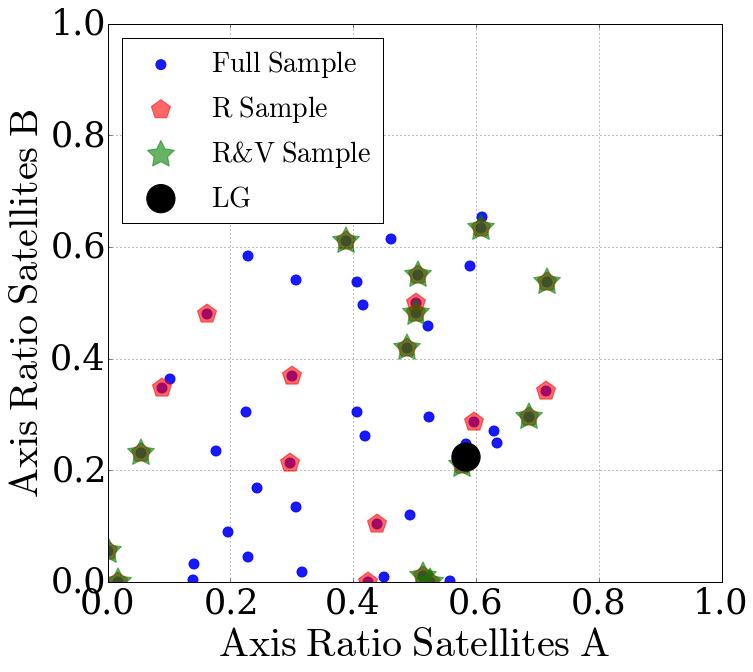

In [169]:
pfig = plt.figure(1, figsize=(11,10))
ax = plt.axes()
set_ticklabels(ax, size=35)

plt.scatter(axratio_bright_A[ifull], axratio_bright_B[ifull],label='$\mathrm{Full\ Sample}$',s=100,alpha=0.9,color='b')

plt.scatter(axratio_bright_A[irsample], axratio_bright_B[irsample], label='$\mathrm{R\ Sample}$',
            s=400,alpha=0.6,color='r', marker=(5,0))


plt.scatter(axratio_bright_A[irvsample], axratio_bright_B[irvsample], label='$\mathrm{R&V\ Sample}$',
            s=800,alpha=0.6,color='green', marker=(5,1))

plt.scatter(axratio_M31, axratio_MW, label='$\mathrm{LG}$',
            s=800,alpha=1.0,color='black', marker='o')

ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.grid(True)

#plt.yscale('log')
#plt.xscale('log')

plt.xlabel(r'${\rm{Axis\ Ratio\ Satellites\ A}}$', size=40)
plt.ylabel(r'${\rm{Axis\ Ratio\ Satellites\ B}}$', size=40)
plt.legend(loc=2, prop={'size':28}, scatterpoints=1)
plt.savefig('../paper/axratio_bright.pdf', bbox_inches='tight')

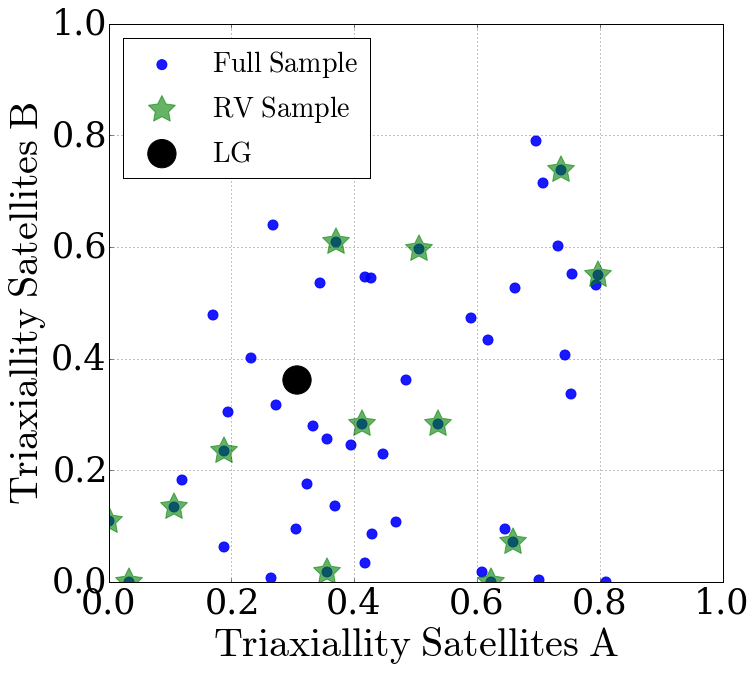

In [170]:
pfig = plt.figure(1, figsize=(11,10))
ax = plt.axes()
set_ticklabels(ax, size=35)

plt.scatter(triax_bright_A[ifull], triax_bright_B[ifull],label='$\mathrm{Full\ Sample}$',s=100,alpha=0.9,color='b')

plt.scatter(triax_bright_A[irvsample], triax_bright_B[irvsample], label='$\mathrm{RV\ Sample}$',
            s=800,alpha=0.6,color='g', marker=(5,1))


plt.scatter(triax_M31, triax_MW,label='$\mathrm{LG}$',
            s=800,alpha=1.0,color='black', marker='o')



ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.grid(True)

#plt.yscale('log')
#plt.xscale('log')

plt.xlabel(r'${\rm{Triaxiallity\ Satellites\ A}}$', size=40)
plt.ylabel(r'${\rm{Triaxiallity\ Satellites\ B}}$', size=40)
plt.legend(loc=2, prop={'size':28}, scatterpoints=1)
plt.savefig('../paper/triax_bright.pdf', bbox_inches='tight')

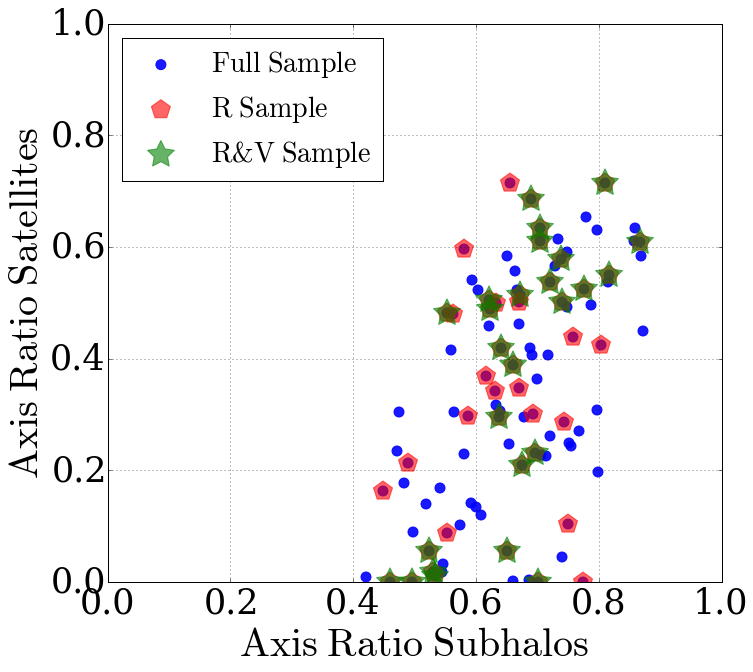

In [171]:
pfig = plt.figure(1, figsize=(11,10))
ax = plt.axes()
set_ticklabels(ax, size=35)

plt.scatter(axratio_dark_A[ifull], axratio_bright_A[ifull],label='$\mathrm{Full\ Sample}$',s=100,alpha=0.9,color='b')
plt.scatter(axratio_dark_B[ifull], axratio_bright_B[ifull],s=100,alpha=0.9,color='b')


plt.scatter(axratio_dark_A[irsample], axratio_bright_A[irsample], label='$\mathrm{R\ Sample}$',
            s=400,alpha=0.6,color='r', marker=(5,0))
plt.scatter(axratio_dark_B[irsample], axratio_bright_B[irsample],
            s=400,alpha=0.6,color='r', marker=(5,0))

plt.scatter(axratio_dark_A[irvsample], axratio_bright_A[irvsample], label='$\mathrm{R&V\ Sample}$',
            s=800,alpha=0.6,color='green', marker=(5,1))
plt.scatter(axratio_dark_B[irvsample], axratio_bright_B[irvsample],
            s=800,alpha=0.6,color='green', marker=(5,1))

ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.grid(True)

#plt.yscale('log')
#plt.xscale('log')

plt.xlabel(r'${\rm{Axis\ Ratio\ Subhalos}}$', size=40)
plt.ylabel(r'${\rm{Axis\ Ratio\ Satellites}}$', size=40)
plt.legend(loc=2, prop={'size':28}, scatterpoints=1)
plt.savefig('../paper/axratio_dark_bright.pdf', bbox_inches='tight')

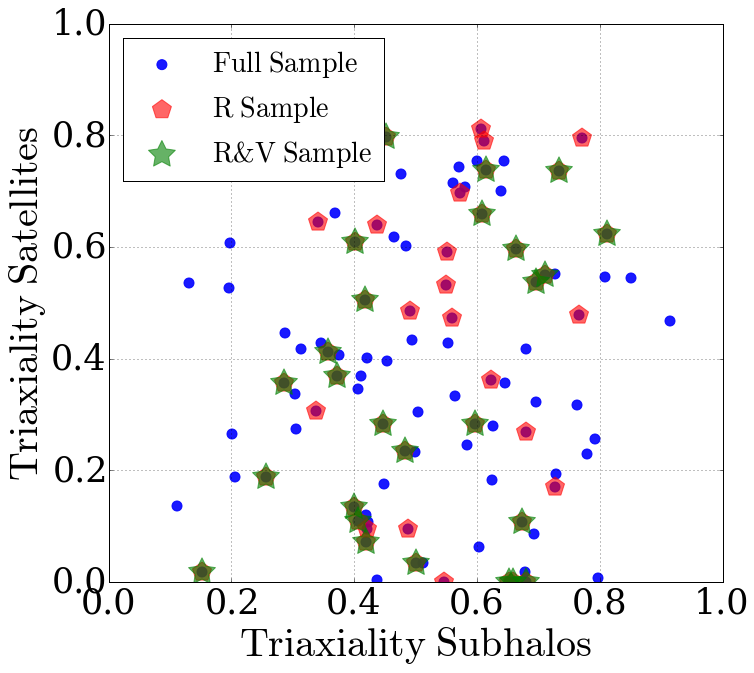

In [172]:
pfig = plt.figure(1, figsize=(11,10))
ax = plt.axes()
set_ticklabels(ax, size=35)

plt.scatter(triax_dark_A[ifull], triax_bright_A[ifull],label='$\mathrm{Full\ Sample}$',s=100,alpha=0.9,color='b')
plt.scatter(triax_dark_B[ifull], triax_bright_B[ifull],s=100,alpha=0.9,color='b')


plt.scatter(triax_dark_A[irsample], triax_bright_A[irsample], label='$\mathrm{R\ Sample}$',
            s=400,alpha=0.6,color='r', marker=(5,0))
plt.scatter(triax_dark_B[irsample], triax_bright_B[irsample],
            s=400,alpha=0.6,color='r', marker=(5,0))

plt.scatter(triax_dark_A[irvsample], triax_bright_A[irvsample], label='$\mathrm{R&V\ Sample}$',
            s=800,alpha=0.6,color='green', marker=(5,1))
plt.scatter(triax_dark_B[irvsample], triax_bright_B[irvsample],
            s=800,alpha=0.6,color='green', marker=(5,1))

ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.grid(True)
#plt.yscale('log')
#plt.xscale('log')

plt.xlabel(r'${\rm{Triaxiality\ Subhalos}}$', size=40)
plt.ylabel(r'${\rm{Triaxiality\ Satellites}}$', size=40)
plt.legend(loc=2, prop={'size':28}, scatterpoints=1)
plt.savefig('../paper/triax_dark_bright.pdf', bbox_inches='tight')

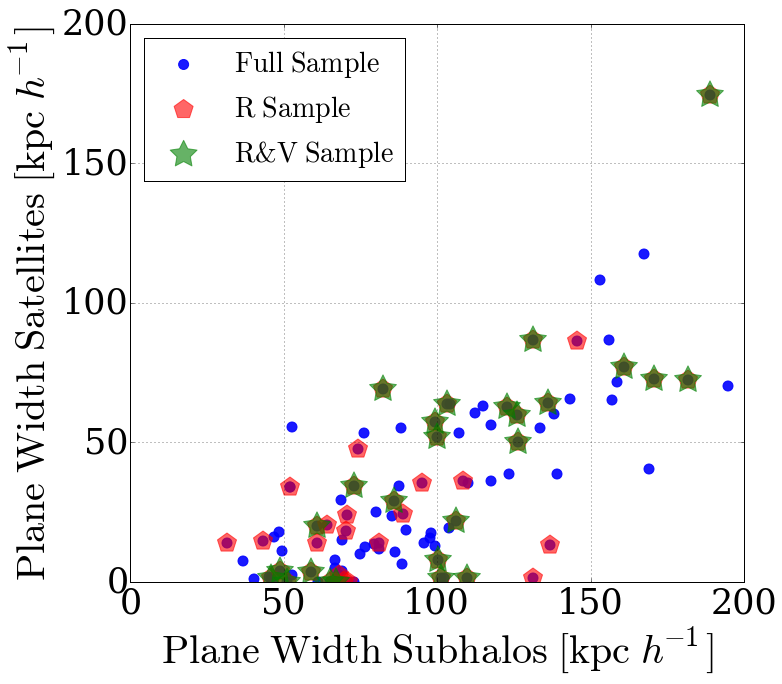

In [173]:
pfig = plt.figure(1, figsize=(11,10))
ax = plt.axes()
set_ticklabels(ax, size=35)

plt.scatter(plane_width_dark_A[ifull], plane_width_bright_A[ifull],label='$\mathrm{Full\ Sample}$',
            s=100,alpha=0.9,color='b')
plt.scatter(plane_width_dark_B[ifull], plane_width_bright_B[ifull],s=100,alpha=0.9,color='b')


plt.scatter(plane_width_dark_A[irsample], plane_width_bright_A[irsample], label='$\mathrm{R\ Sample}$',
            s=400,alpha=0.6,color='r', marker=(5,0))
plt.scatter(plane_width_dark_B[irsample], plane_width_bright_B[irsample],
            s=400,alpha=0.6,color='r', marker=(5,0))

plt.scatter(plane_width_dark_A[irvsample], plane_width_bright_A[irvsample], label='$\mathrm{R&V\ Sample}$',
            s=800,alpha=0.6,color='green', marker=(5,1))
plt.scatter(plane_width_dark_B[irvsample], plane_width_bright_B[irvsample],
            s=800,alpha=0.6,color='green', marker=(5,1))

ax.set_xlim([0,200])
ax.set_ylim([0,200])
ax.grid(True)
#plt.yscale('log')
#plt.xscale('log')

plt.xlabel(r'${{\rm{Plane\ Width\ Subhalos}}\ [{\rm{kpc}}\ h^{-1}]}$', size=40)
plt.ylabel(r'${{\rm{Plane\ Width\ Satellites}}\ [{\rm{kpc}}\ h^{-1}]}$', size=40)
plt.legend(loc=2, prop={'size':28}, scatterpoints=1)
plt.savefig('../paper/plane_width.pdf', bbox_inches='tight')

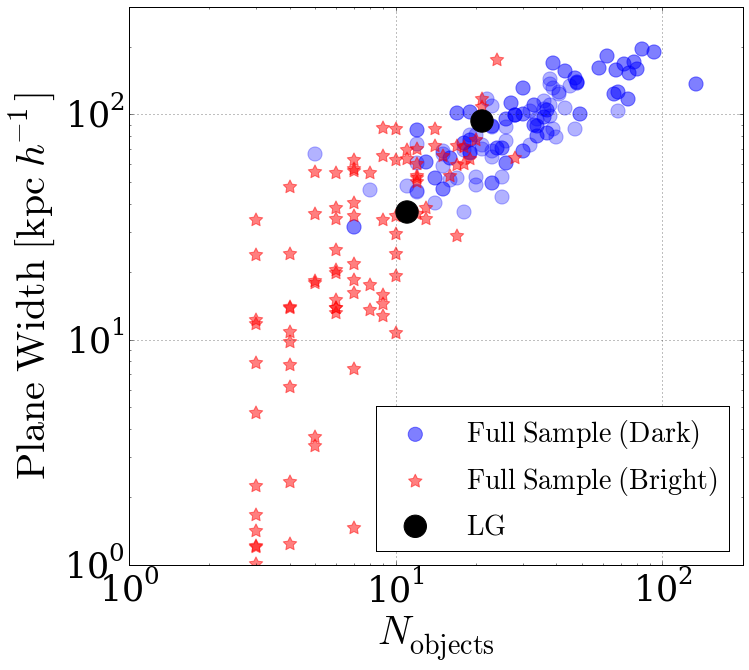

In [174]:
pfig = plt.figure(1, figsize=(11,10))
ax = plt.axes()
set_ticklabels(ax, size=35)

plt.scatter(n_dark_A[ifull], plane_width_dark_A[ifull],
                label='$\mathrm{Full\ Sample\ (Dark)}$',s=200,alpha=0.5,color='b')
plt.scatter(n_dark_B[ifull], plane_width_dark_B[ifull],s=200,alpha=0.3,color='b')

plt.scatter(n_bright_A[ifull], plane_width_bright_A[ifull],
                label='$\mathrm{Full\ Sample\ (Bright)}$',s=200,alpha=0.5,color='red', marker=(5,1))
plt.scatter(n_bright_B[ifull], plane_width_bright_B[ifull],s=200,alpha=0.5,color='red',marker=(5,1))

hubble = 0.73
plt.scatter([n_MW, n_M31], [MW_plane_delta*hubble, M31_plane_delta*hubble],s=500,alpha=1.0,color='black',marker='o',
           label='$\mathrm{LG}$')

ax.set_xlim([1,200])
ax.set_ylim([1,300])
ax.grid(True)
plt.yscale('log')
plt.xscale('log')

plt.xlabel(r'$N_{\rm{objects}}$', size=40)
plt.ylabel(r'${{\rm{Plane\ Width}}\ [{\rm{kpc}}\ h^{-1}]}$', size=40)
plt.legend(loc=4, prop={'size':28}, scatterpoints=1)
plt.savefig('../paper/plane_width_n_dark.pdf', bbox_inches='tight')

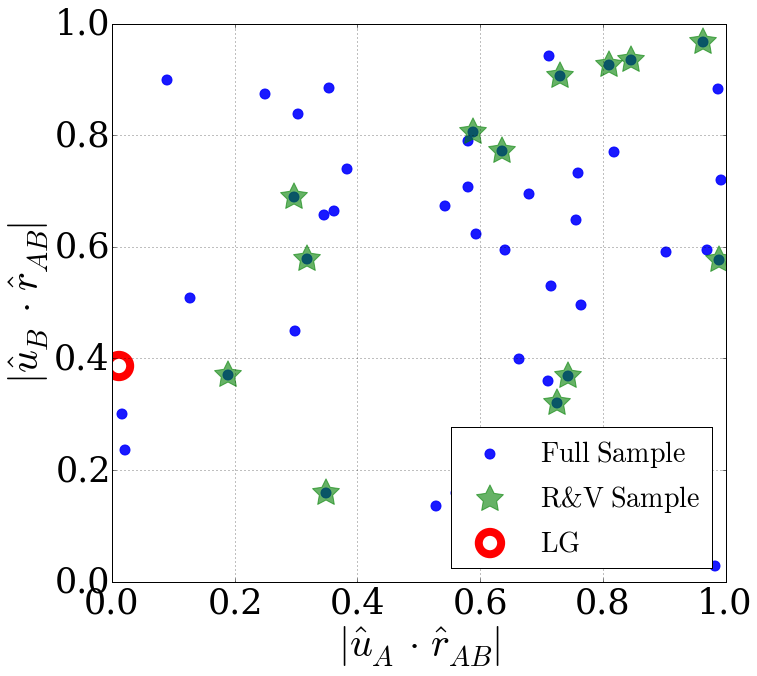

In [175]:
pfig = plt.figure(1, figsize=(11,10))
ax = plt.axes()
set_ticklabels(ax, size=35)

plt.scatter(dot_product_r_bright_A[ifull], dot_product_r_bright_B[ifull],
                label='$\mathrm{Full\ Sample}$',s=100,alpha=0.9,color='b')

plt.scatter(dot_product_r_bright_A[irvsample], dot_product_r_bright_B[irvsample],
                label='$\mathrm{R&V\ Sample}$',s=800,alpha=0.6,color='green', marker=(5,1))

hubble = 0.73
plt.scatter(dot_product_r_M31, dot_product_r_MW,s=500,alpha=1.0,
            facecolors='white', edgecolors='r', label='$\mathrm{LG}$', linewidth=8)


ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.grid(True)
#plt.yscale('log')
#plt.xscale('log')

plt.xlabel(r'$|\hat{u}_A\cdot\ \hat{r}_{AB}|$', size=40)
plt.ylabel(r'$|\hat{u}_B\cdot\ \hat{r}_{AB}|$', size=40)
plt.legend(loc=4, prop={'size':28}, scatterpoints=1)
plt.savefig('../paper/r_u_alignment.pdf', bbox_inches='tight')

In [29]:
ab_full, ax_full, bx_full = monte_carlo_sample_pairs(n_monte_carlo=20000, \
                                    list_N_points_A=np.int_(n_bright_A[ifull]), \
                                    list_N_points_B=np.int_(n_bright_B[ifull]))
ab_rvsample, ax_rvsample, bx_rvsample = monte_carlo_sample_pairs(n_monte_carlo=20000, \
                                    list_N_points_A=np.int_(n_bright_A[irvsample]), \
                                    list_N_points_B=np.int_(n_bright_B[irvsample]))

In [140]:
ab_full_dark, ax_full_dark, bx_full_dark = monte_carlo_sample_pairs(n_monte_carlo=20000, \
                                    list_N_points_A=np.int_(n_dark_A[ifull]), \
                                    list_N_points_B=np.int_(n_dark_B[ifull]))
ab_rvsample_dark, ax_rvsample_dark, bx_rvsample_dark = monte_carlo_sample_pairs(n_monte_carlo=20000, \
                                    list_N_points_A=np.int_(n_dark_A[irvsample]), \
                                    list_N_points_B=np.int_(n_dark_B[irvsample]))

In [203]:
def plot_significance(ax_data, bx_data, dot_a_data, dot_b_data, index_data, name='full_bright', label=r'$a$'):
    pfig = plt.figure(1, figsize=(11,10))
    ax = plt.axes()
    set_ticklabels(ax, size=35)

    args = {"linewidths": 4}

    cont = density_contour(ax_data, bx_data, 15, 15, **args)
    fmt = {}
    strs = [r'$1\sigma$', r'$2\sigma$', r'$3\sigma$']
    for l, s in zip(cont.levels, strs):
        fmt[l] = s
    labels = plt.clabel(cont, inline=1, fontsize=40, fmt=fmt)
    for l in labels:
        l.set_rotation(0)

    mu_A = dot_a_data[index_data]
    mu_B = dot_b_data[index_data]
    plt.scatter(np.median(mu_A), np.median(mu_B),s=1000,c='black', marker=(5,1), label=label)
    ax.set_xlim([0,1.0])
    ax.set_ylim([0,1.0])
    ax.grid(True)
    plt.xlabel(r'${\rm median}\ |\hat{u}_A\cdot\ \hat{r}_{AB}|$', size=40)
    plt.ylabel(r'${\rm median}\ |\hat{u}_B\cdot\ \hat{r}_{AB}|$', size=40)
    plt.legend(loc=4, prop={'size':28}, scatterpoints=1)
    plt.savefig('../paper/significance_{}.pdf'.format(name), bbox_inches='tight')

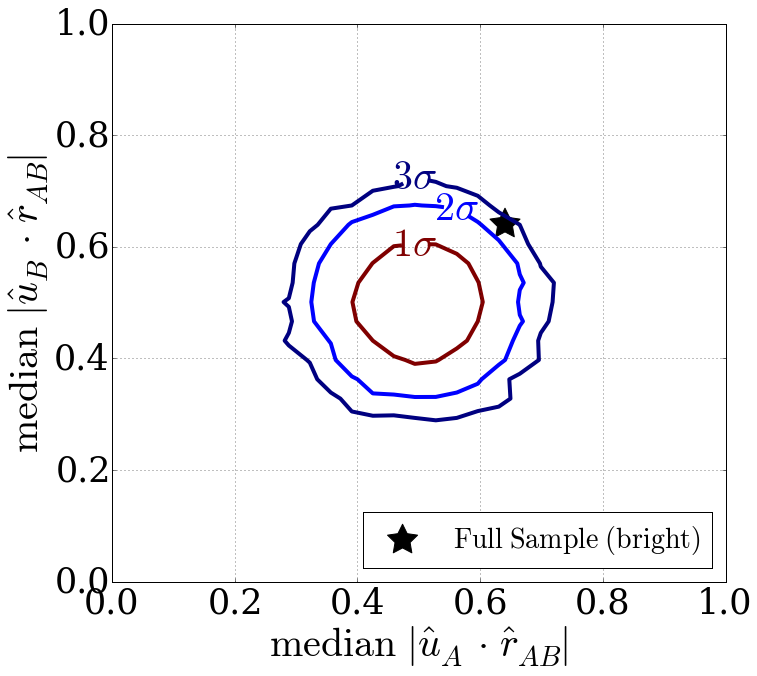

In [204]:
plot_significance(ax_full, bx_full, dot_product_r_bright_A, dot_product_r_bright_A, ifull, 
                  name='full_bright', label=r'$\rm{Full\ Sample\ (bright)}$')

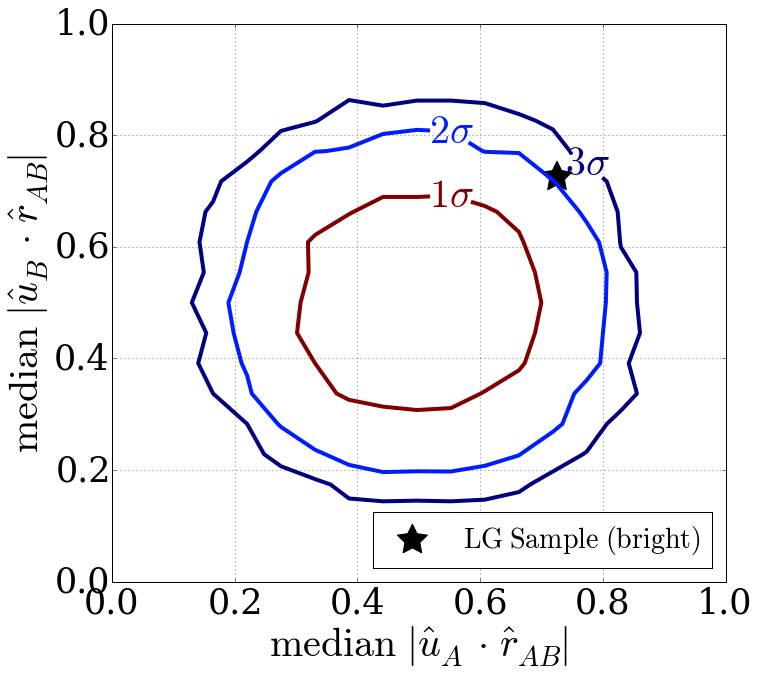

In [205]:
plot_significance(ax_rvsample, bx_rvsample, dot_product_r_bright_A, dot_product_r_bright_A, irvsample, 
                  name='lg_bright', label=r'$\rm{LG\ Sample\ (bright)}$')

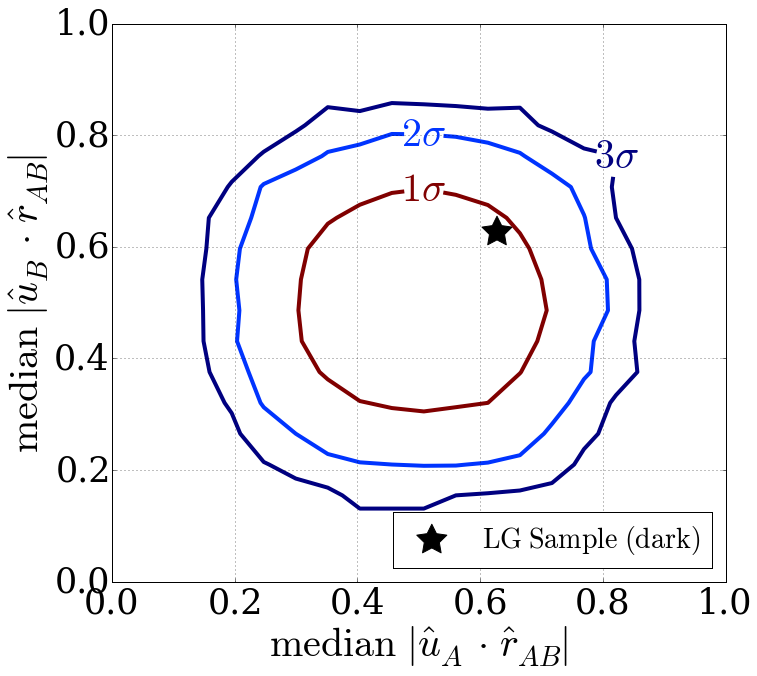

In [206]:
plot_significance(ax_rvsample_dark, bx_rvsample_dark, dot_product_r_dark_A, dot_product_r_dark_A, irvsample, 
                  name='lg_dark', label=r'$\rm{LG\ Sample\ (dark)}$')

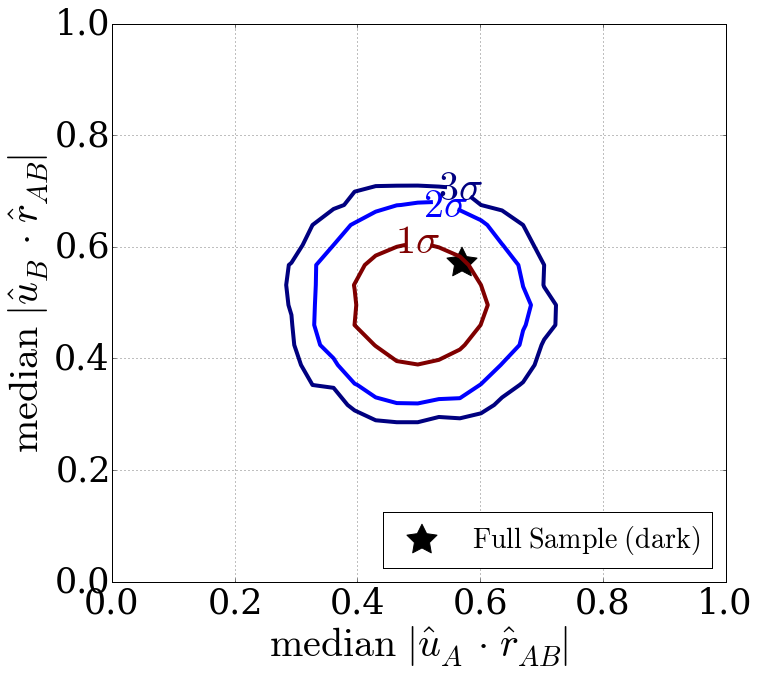

In [207]:
plot_significance(ax_full_dark, bx_full_dark, dot_product_r_dark_A, dot_product_r_dark_A, ifull, 
                  name='full_dark', label=r'$\rm{Full\ Sample\ (dark)}$')